In [1]:
!pip install anndata pandas h5py


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.3 MB/s eta 0:00:00


In [2]:

from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
import anndata
import pandas as pd
import os

os.chdir('/content/drive/MyDrive')
# Load the .h5ad file
adata = anndata.read_h5ad("GTEx_8_tissues_snRNAseq_atlas_071421.public_obs.h5ad", backed='r')

# Extract data
X = adata.X  # Gene expression matrix
obs = adata.obs  # Cell metadata
var = adata.var  # Gene metadata

X_df = pd.DataFrame(X.toarray() if hasattr(X, "toarray") else X,
                    index=obs.index,  # Cell names
                    columns=var.index)  # Gene names


In [4]:
import anndata
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#import dask.array as da

# Extract the expression matrix and metadata
X = adata.X  # Gene expression matrix
y = adata.obs["tissue"]  # Tissue type (target variable)

#saving tissue labels
tissue_labels = pd.get_dummies(y).columns

# Encode target variable
y = pd.get_dummies(y).values  # One-hot encode tissue types

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer, relu 1
    Dropout(0.3),  # Dropout 1
    Dense(128, activation='relu'),  # Hidden layer, relu 2
    Dropout(0.3), # Dropout 2
    Dense(y_train.shape[1], activation='softmax')  # Output layer, softmax
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    epochs=10,
                    batch_size=32,
                    callbacks=[early_stopping])


Epoch 1/25
5229/5229 [==============================] - 191s 36ms/step - loss: 0.1591 - accuracy: 0.9493 - val_loss: 0.0590 - val_accuracy: 0.9818
Epoch 2/25
5229/5229 [==============================] - 186s 35ms/step - loss: 0.0547 - accuracy: 0.9834 - val_loss: 0.0708 - val_accuracy: 0.9790
Epoch 3/25
5229/5229 [==============================] - 182s 35ms/step - loss: 0.0401 - accuracy: 0.9887 - val_loss: 0.0639 - val_accuracy: 0.9817
Epoch 4/25
5229/5229 [==============================] - 185s 35ms/step - loss: 0.0330 - accuracy: 0.9912 - val_loss: 0.0659 - val_accuracy: 0.9835
Epoch 5/25
5229/5229 [==============================] - 184s 35ms/step - loss: 0.0260 - accuracy: 0.9934 - val_loss: 0.0756 - val_accuracy: 0.9826
Epoch 6/25
5229/5229 [==============================] - 184s 35ms/step - loss: 0.0229 - accuracy: 0.9943 - val_loss: 0.0821 - val_accuracy: 0.9840


1308/1308 [==============================] - 17s 13ms/step - loss: 0.0590 - accuracy: 0.9818
Test Accuracy: 0.98


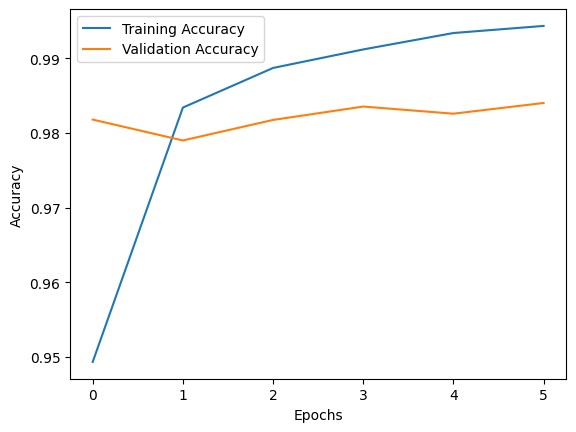

In [ ]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Plot training and validation accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Save the trained model
model.save("trained_model")


NameError: name 'model' is not defined

In [5]:
from tensorflow.keras.models import load_model
import os
os.chdir('/content/drive/MyDrive')
# Load the trained model
model = load_model("trained_model")


In [6]:
import numpy as np

# Predict probabilities
predictions = model.predict(X_test)

# Convert to class indices
predicted_classes = predictions.argmax(axis=1)
true_classes = y_test.argmax(axis=1)


1308/1308 [==============================] - 14s 11ms/step


In [9]:
# Correct predictions
correct_predictions = (predicted_classes == true_classes)
# Incorrect predictions
incorrect_predictions = (predicted_classes != true_classes)

print(f"Number of correct predictions: {len(correct_predictions)}")
print(f"Number of incorrect predictions: {len(incorrect_predictions)}")

Number of correct predictions: 41826
Number of incorrect predictions: 41826


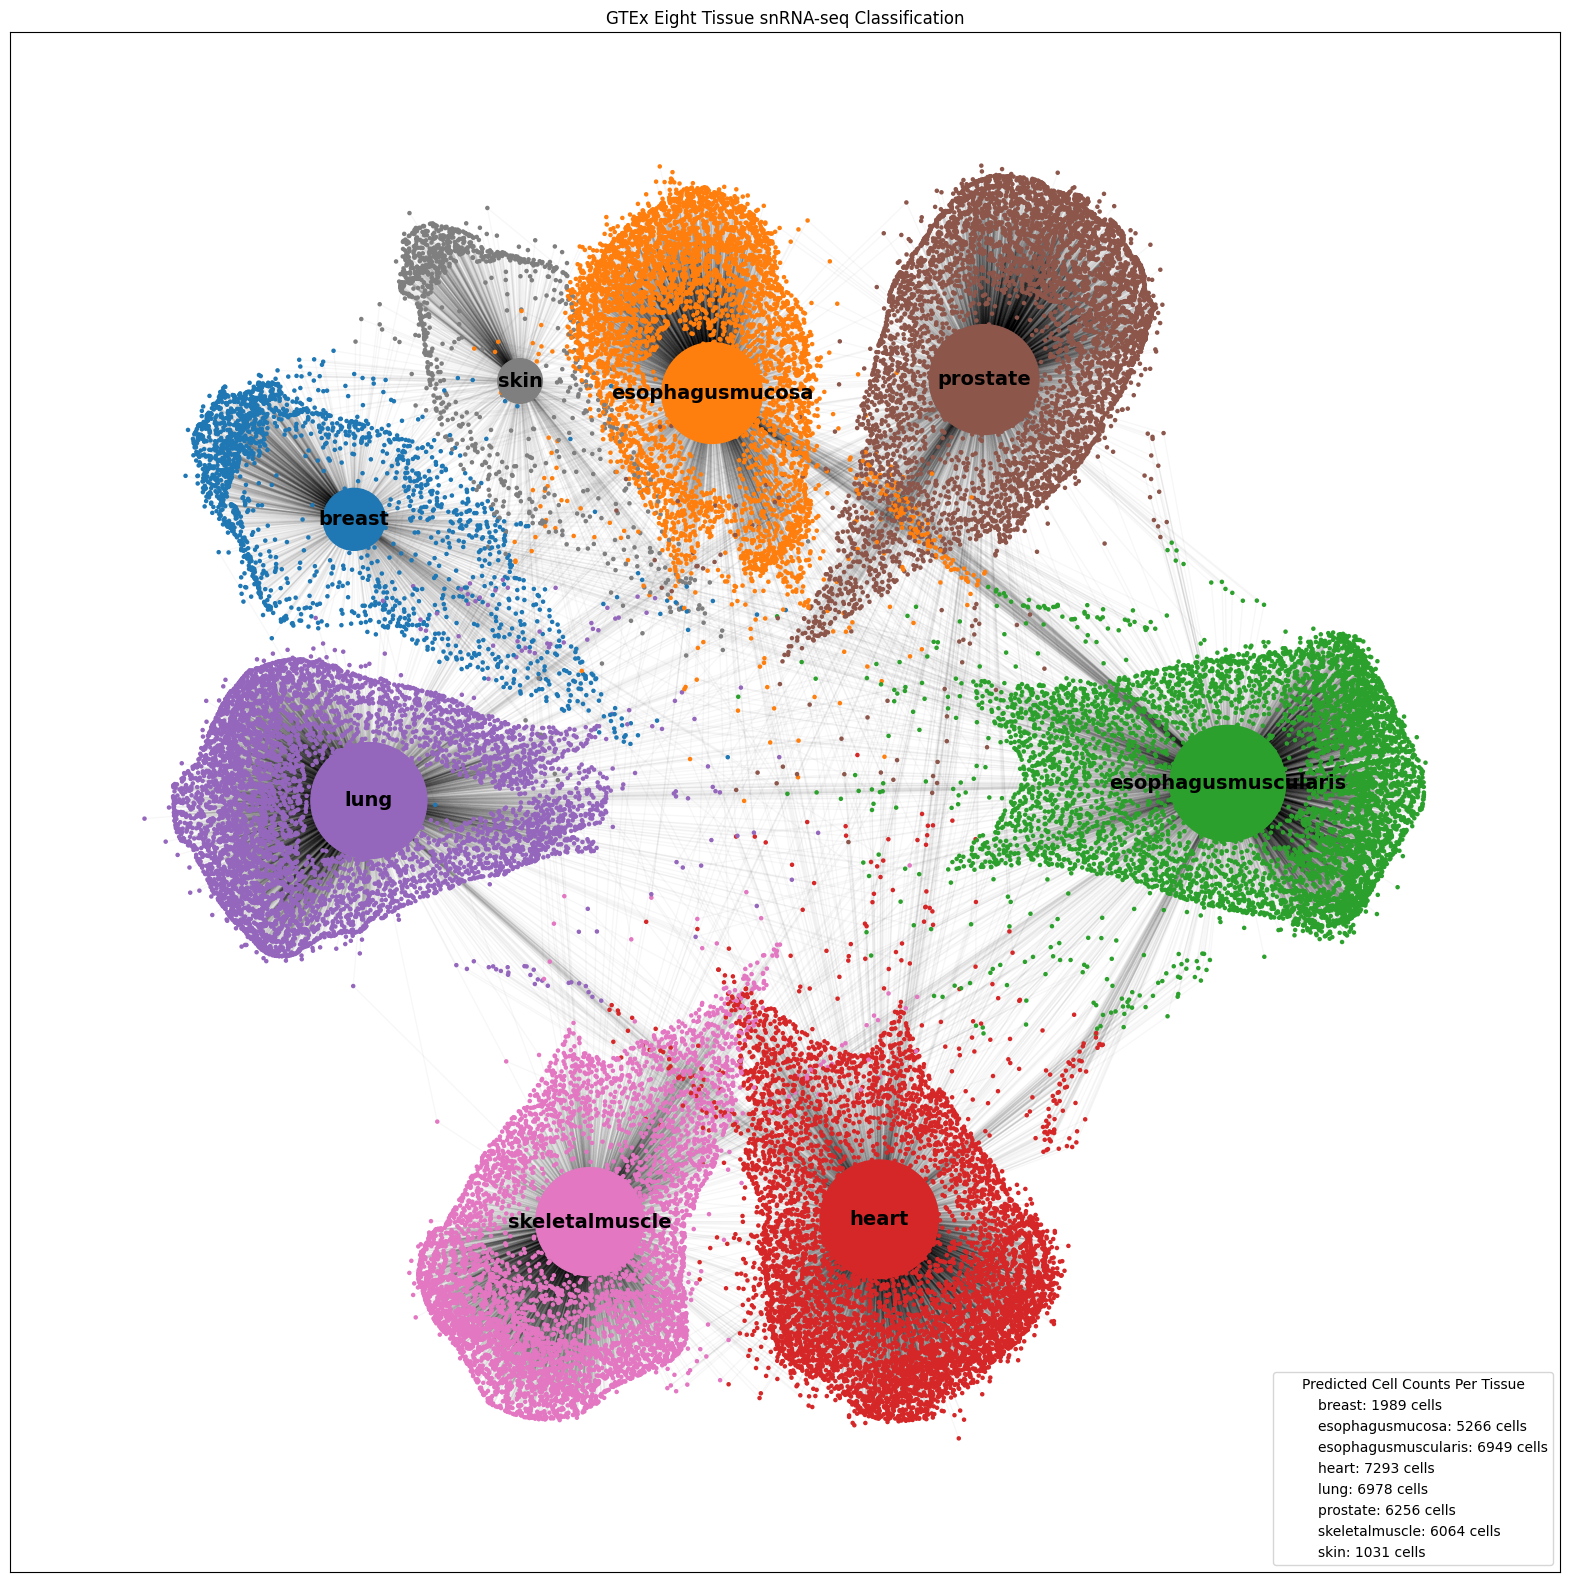

In [7]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors

tissue_colors = {tissue: color for tissue, color in zip(tissue_labels, mcolors.TABLEAU_COLORS)}  # Assign distinct colors

# Step 2: Build the graph and calculate tissue association counts
G = nx.Graph()

# Initialize a counter for the number of cells associated with each tissue
tissue_cell_counts = {tissue: 0 for tissue in tissue_labels}

# Add tissue nodes
for tissue in tissue_labels:
    G.add_node(tissue, type="tissue", color=tissue_colors[tissue])

# Add cell nodes and proportional edges
cell_colors = []  # To store the colors of cell nodes
for i, prediction in enumerate(predictions):
  cell_node = f"Cell_{i}"
  G.add_node(cell_node, type="cell")  # Add cell nodes

  # Find the strongest tissue association
  strongest_tissue_idx = np.argmax(prediction)  # Index of the strongest weight
  strongest_tissue = tissue_labels[strongest_tissue_idx]
  cell_colors.append(tissue_colors[strongest_tissue])  # Assign the tissue color to the cell

  # Increment the count for the associated tissue
  tissue_cell_counts[strongest_tissue] += 1

  # Add edges for the cell
  for j, strength in enumerate(prediction):
    if strength > 0.10:  # Threshold for edge creation
      G.add_edge(cell_node, tissue_labels[j], weight=strength)

# Step 4: Compute spring layout for cell nodes with tissue positions fixed
positions = nx.spring_layout(G, weight="weight", seed=7, k=0.01, iterations=15)

# Step 5: Visualization
plt.figure(figsize=(20, 20))

# Draw cell nodes with their assigned colors
nx.draw_networkx_nodes(
    G,
    positions,
    nodelist=[node for node in G.nodes if G.nodes[node]["type"] == "cell"],
    node_color=cell_colors,
    node_size=5,
    label="Cell Nodes"
)

# Draw tissue nodes
nx.draw_networkx_nodes(
    G,
    positions,
    nodelist=tissue_labels,
    node_color=[tissue_colors[tissue] for tissue in tissue_labels],
    node_size=[tissue_cell_counts[tissue] for tissue in tissue_labels],
    label="Tissue Nodes"
)

# Add tissue node labels
nx.draw_networkx_labels(
    G,
    positions,
    labels={tissue: tissue for tissue in tissue_labels},
    font_size=14,
    font_color="black",
    font_weight="bold",
)

# Draw edges
nx.draw_networkx_edges(
    G,
    positions,
    width=1,
    alpha=0.03
)


# Add a legend showing tissue cell counts
legend_labels = [f"{tissue}: {tissue_cell_counts[tissue]} cells" for tissue in tissue_labels]

# Create dummy handles for the legend
handles = [plt.Line2D([], [], color='none', label=label) for label in legend_labels]
plt.legend(handles=handles, loc="lower right", fontsize=10, title="Predicted Cell Counts Per Tissue")
plt.title("GTEx Eight Tissue snRNA-seq Classification")

plt.savefig("tissue_classification.png", format="png", dpi=300, bbox_inches="tight")
plt.show()


In [11]:
plt.savefig("tissue_classification.png", format="png", dpi=300, bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

In [ ]:
import pickle

# Save the graph
with open("graph.pkl", "wb") as f:
    pickle.dump(G, f)

# Load the graph
with open("graph.pkl", "rb") as f:
    G = pickle.load(f)
